# Sequential probability ratio test simulations

Sequential testing procedure from Weiss (1962)

The method tests the null hypothesis that a multinomial random variable has equal category probabilities $1/k$ against the alternative that the most common $s$ categories have a probability of occuring more often than $s/k$.


The function `sequential_multinomial_test` tests the null with type 1 error at most $\alpha$ and power at least $1 - \beta$.

The inequalities hold when $\beta = 0$ also. Then the likelihood ratio has chance at most $\alpha$ of ever being greater than $1/\alpha$, if in fact $p > p_0$.

Hence, $1/\mbox{LR}$ is the $P$-value of the hypothesis $p > p_0$. If $d$ is the number of times that an observation is among the most common $s$ values and we stop the test after $m$ steps, then the likelihood ratio is

$$LR = \frac{p_1^d (1-p_1)^{m-d}}{p_0^d (1-p_0)^{m-d}}$$

This simplifies if we set $p_1 = \kappa p_0$.

$$LR = \frac{\kappa^d (1-\kappa s/k)^{m-d}}{(1- s/k)^{m/d}}$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
def sample_from_multinomial(probs):
    '''
    Draw a single sample from a multinomial distribution with selection probabilities given by probs
    '''
    draw_sample = np.random.multinomial(1, probs)
    Xn = np.where(draw_sample > 0)[0][0] + 1
    return Xn


def sequential_multinomial_test(sampling_function, num_categories, alpha, beta, multiplier, \
                                s = None, maxsteps=10**5):
    '''
    Conduct Wald's SPRT for multinomial distribution with num_categories categories
    Let p = sum_{s most frequent categories} p_category
    H_0: selection probabilities are all 1/num_categories so p=s/num_categories
    H_1: p = p1 = multiplier * s/num_categories
    
    sampling_function: a function which generates a random number or random sample.
    num_categories: number of categories
    alpha: desired type 1 error rate
    beta: desired power
    multiplier: value larger than 1. Determines alternative: p1 = multiplier * s/num_categories
    s: tuning parameter, integer between 1 and k. Default is 1% of num_categories.
    '''

    assert multiplier > 1
    assert maxsteps > 0
    
    if s is None:
        s = math.ceil(0.01*num_categories)
    assert isinstance(s, int)    


    k = num_categories # Rename for ease of use!
    
    # Set p0 = s/k, p1 = multiplier*(s/k)
    # Set parameters
    if beta == 0:
        a = [math.log(beta/(1-alpha)) / ( math.log(multiplier)-math.log( (k-multiplier*s)/(k-s) ))]
    else:
        a = [math.log(beta/(1-alpha)) / ( math.log(multiplier)-math.log( (k-multiplier*s)/(k-s) ))]
    r = [math.log((1-beta)/alpha) / ( math.log(multiplier)-math.log( (k-multiplier*s)/(k-s) ))]
    increment = math.log( (k-s)/ (k-multiplier*s)) / ( math.log(multiplier)-math.log( (k-multiplier*s)/(k-s) ))
    d = [0]

    # Initialize counter
    sampleCounts = dict()
    steps = 0
    LR = [1]
    
    # Draw samples
    while a[-1] < d[-1] < r[-1] and steps < maxsteps:
        Xn = sampling_function()
            
        if s > len(sampleCounts):
            if Xn in sampleCounts.keys():
                sampleCounts[Xn] += 1
            else:
                sampleCounts[Xn] = 1
            continue
            
        
        # Event occurs if Xn is among the top s most frequent values of X1,...,X_n-1
        steps += 1
        top_categories = sorted(sampleCounts, key = sampleCounts.get)[:s]
        if Xn in top_categories:
            Bn = 1
            LR.append(LR[-1] * multiplier)
        else:
            Bn = 0
            LR.append(LR[-1] * (1 - multiplier*s/k)/(1 - s/k))
        # Run test at step n
        d = d + [d[-1]+Bn]
        a = a + [a[-1]+increment]
        r = r + [r[-1]+increment]

        if d[-1] <= a[-1]:
            # accept the null and stop
            return {'decision' : 0,
                    'a' : a,
                    'd' : d,
                    'r' : r,
                    'steps' : steps,
                    'pvalue' : LR[-1]
                   }
        if d[-1] >= r[-1]:
            # reject the null and stop
            return {'decision' : 1,
                    'a' : a,
                    'd' : d,
                    'r' : r,
                    'steps' : steps,
                    'pvalue' : LR[-1]
                   }
        
        # add Xn to sampleCounts and repeat
        if Xn in sampleCounts.keys():
            sampleCounts[Xn] += 1
        else:
            sampleCounts[Xn] = 1

# SPRT under the null

In [3]:
# Choose s, multiplier > 1, alpha, beta
k = 1000
s = 10
alpha = 0.05
beta = 0.2
multiplier = 1.2

# Under null:
np.random.seed(547691802) # from random.org Timestamp: 2017-01-14 22:56:40 UTC

null_sampling_function = lambda: sample_from_multinomial([1/k]*k)
res = sequential_multinomial_test(sampling_function = null_sampling_function,
                                num_categories=k, alpha=alpha, beta=0.2, multiplier=multiplier)
res['decision'], res['steps'], res['pvalue']

(0, 1318, 0.21029234468724897)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


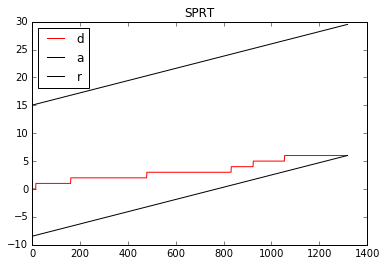

In [4]:
plt.gca().set_color_cycle(['red', 'black', 'black'])

plt.plot(list(range(res['steps']+1)), res['d'])
plt.plot(list(range(res['steps']+1)), res['a'])
plt.plot(list(range(res['steps']+1)), res['r'])
plt.legend(['d', 'a', 'r'], loc='upper left')
plt.title("SPRT")
plt.show()

## Level of test

We'll run the SPRT 100 (1000?) times and compute the actual level under the null when we set $\alpha = 0.05$.



In [5]:
# Choose s, multiplier > 1, alpha, beta
k = 1000
s = 10
alpha = 0.05
beta = 0.2
multiplier = 1.2
null_sampling_function = lambda: sample_from_multinomial([1/k]*k)
np.random.seed(547691802) # from random.org Timestamp: 2017-01-14 22:56:40 UTC

decision = []
steps = []
pvalue = []
numB = []

for j in range(10):
    
    res = sequential_multinomial_test(sampling_function = null_sampling_function,
                                num_categories=k, alpha=alpha, beta=beta, multiplier=multiplier)
    decision.append(res['decision'])
    steps.append(res['steps'])
    pvalue.append(res['pvalue'])
    numB.append(res['d'][-1])

Rejection rate: 0.1
Average number of trials: 7301.1


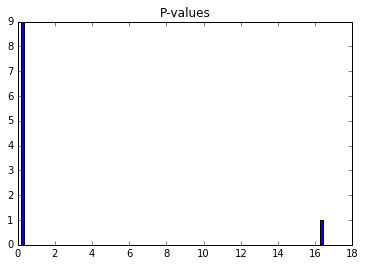

In [6]:
print("Rejection rate: " + str(np.mean(decision)))

print("Average number of trials: " + str(np.mean(steps)))

plt.hist(pvalue, bins = 100)
plt.title("P-values")
plt.show()

# SPRT under an alternative

In [7]:
probs = [1/k]*k
probs[:s] = [1.5/k]*s
probs[-s:] = [0.5/k]*s
alt_sampling_function = lambda: sample_from_multinomial(probs)

np.random.seed(323) # from random.org Timestamp: 2017-01-14 22:56:40 UTC
res1 = sequential_multinomial_test(sampling_function = alt_sampling_function,
                                num_categories=k, alpha=alpha, beta=0.05, multiplier=1.2)
res1['decision'], res1['steps'], res1['pvalue']

(0, 10208, 0.052545498946582454)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


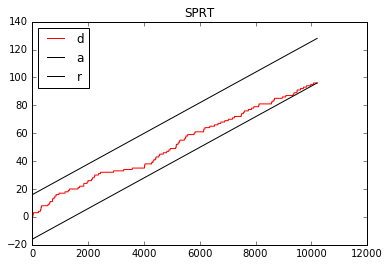

In [8]:
plt.gca().set_color_cycle(['red', 'black', 'black'])

plt.plot(list(range(res1['steps']+1)), res1['d'])
plt.plot(list(range(res1['steps']+1)), res1['a'])
plt.plot(list(range(res1['steps']+1)), res1['r'])
plt.legend(['d', 'a', 'r'], loc='upper left')
plt.title("SPRT")
plt.show()